# Contour Detection from STFT
* Detect closed contours over STFT magnitude (e.g., |Zxx| > 1e-3).
* I can extract their area, duration, central frequency, etc.

In [ ]:
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import stft
from skimage import measure




In [3]:
# List of shot IDs
shot_ids = [23447, 30005, 30021, 30421]  # Add more as needed

# S3 endpoint
endpoint = "https://s3.echo.stfc.ac.uk"
fs = fsspec.filesystem(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint)
)

In [4]:
store_list = []
zgroup_list = []

In [5]:
# Loop through each shot ID
for shot_id in shot_ids:
    url = f"s3://mast/level2/shots/{shot_id}.zarr"
    
    store = zarr.storage.FSStore(fs=fs, url=url)
    store_list.append(store)
    # open or download the Zarr group
    try:
        zgroup_list.append(zarr.open(store, mode='r'))
        print(f"Loaded shot ID {shot_id}")
        # Do something with zgroup here, like listing arrays:
        # print(list(zgroup.array_keys()))
    except Exception as e:
        print(f"Failed to load shot ID {shot_id}: {e}")

Loaded shot ID 23447
Loaded shot ID 30005
Loaded shot ID 30021
Loaded shot ID 30421


In [6]:
# for store in zgroup:
#     root = zarr.open_group(store, mode='r')
mirnov = [xr.open_zarr(store, group="magnetics") for store in store_list]
mirnov[0]

<xarray.Dataset> Size: 32MB
Dimensions:                                   (b_field_pol_probe_cc_channel: 5,
                                               time_mirnov: 261200,
                                               b_field_pol_probe_ccbv_channel: 40,
                                               time: 2612,
                                               b_field_pol_probe_obr_channel: 18,
                                               b_field_pol_probe_obv_channel: 18,
                                               b_field_pol_probe_omv_channel: 3,
                                               b_field_tor_probe_cc_channel: 3,
                                               b_field_tor_probe_saddle_field_channel: 12,
                                               time_saddle: 26120,
                                               b_field_tor_probe_saddle_voltage_channel: 12,
                                               flux_loop_channel: 15)
Coordinates:
  * b_field_pol_probe_cc_channel              (b_field_pol_probe_cc_channel) <U13 260B ...
  * b_field_pol_probe_ccbv_channel            (b_field_pol_probe_ccbv_channel) <U10 2kB ...
  * b_field_pol_probe_obr_channel             (b_field_pol_probe_obr_channel) <U9 648B ...
  * b_field_pol_probe_obv_channel             (b_field_pol_probe_obv_channel) <U9 648B ...
  * b_field_pol_probe_omv_channel             (b_field_pol_probe_omv_channel) <U11 132B ...
  * b_field_tor_probe_cc_channel              (b_field_tor_probe_cc_channel) <U13 156B ...
  * b_field_tor_probe_saddle_field_channel    (b_field_tor_probe_saddle_field_channel) <U11 528B ...
  * b_field_tor_probe_saddle_voltage_channel  (b_field_tor_probe_saddle_voltage_channel) <U15 720B ...
  * flux_loop_channel                         (flux_loop_channel) <U12 720B '...
  * time                                      (time) float64 21kB -0.099 ... ...
  * time_mirnov                               (time_mirnov) float64 2MB -0.09...
  * time_saddle                               (time_saddle) float64 209kB -0....
Data variables:
    b_field_pol_probe_cc_field                (b_field_pol_probe_cc_channel, time_mirnov) float64 10MB ...
    b_field_pol_probe_ccbv_field              (b_field_pol_probe_ccbv_channel, time) float64 836kB ...
    b_field_pol_probe_obr_field               (b_field_pol_probe_obr_channel, time) float64 376kB ...
    b_field_pol_probe_obv_field               (b_field_pol_probe_obv_channel, time) float64 376kB ...
    b_field_pol_probe_omv_voltage             (b_field_pol_probe_omv_channel, time_mirnov) float64 6MB ...
    b_field_tor_probe_cc_field                (b_field_tor_probe_cc_channel, time_mirnov) float64 6MB ...
    b_field_tor_probe_saddle_field            (b_field_tor_probe_saddle_field_channel, time_saddle) float64 3MB ...
    b_field_tor_probe_saddle_voltage          (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 3MB ...
    flux_loop_flux                            (flux_loop_channel, time) float64 313kB ...
    ip                                        (time) float64 21kB ...
Attributes:
    description:  
    imas:         magnetics
    label:        Plasma Current
    name:         magnetics
    uda_name:     AMC_PLASMA CURRENT
    units:        A

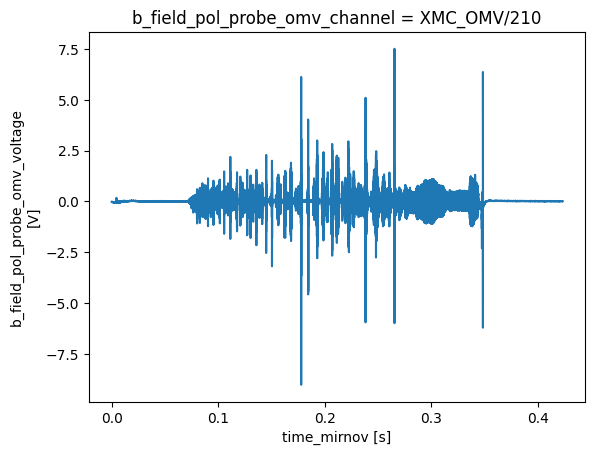

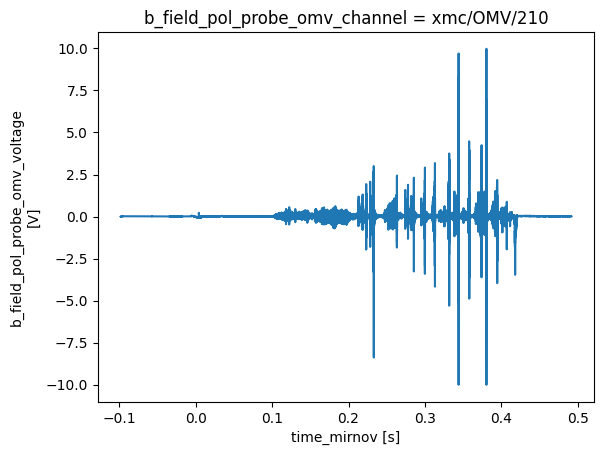

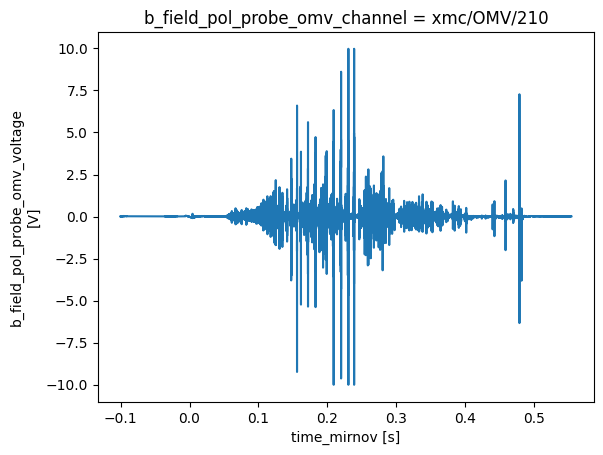

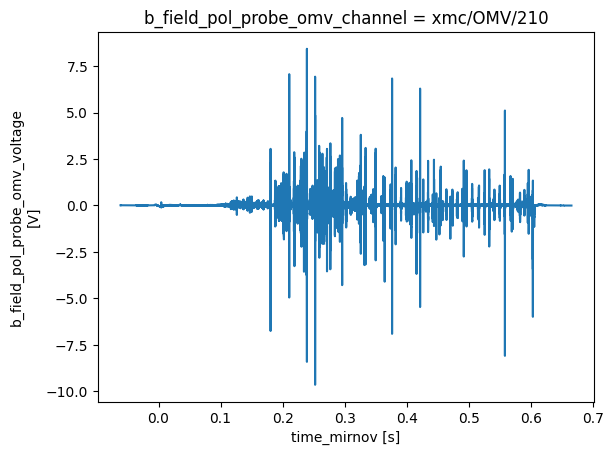

In [7]:
# Extract the DataArrays
ds_list = [m['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1) for m in mirnov]

# Plot all in one figure

for i, ds in enumerate(ds_list):
    plt.figure(i)
    ds.plot(label=f"Shot {i}")

##  Short-Time Fourier Transform (STFT)

In [ ]:
def plot_stft_spectrogram(    ds,    shot_id=None,    nperseg=2000,    nfft=2000,    tmin=0.1,    tmax=0.46,    fmax_kHz=50,    cmap='jet'):
    """
    Plot STFT short time Fourier transform spectrogram for a given xarray DataArray `ds`.
    
    Parameters:
    - ds: xarray.DataArray with a 'time_mirnov' coordinate.
    - shot_id: Optional shot ID for labeling.
    - nperseg: Number of points per STFT segment.
    - nfft: Number of FFT points.
    - tmin, tmax: Time range to display (seconds).
    - fmax_kHz: Max frequency to display (kHz).
    - cmap: Colormap name.
    """
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"STFT Spectrogram"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()

[None, None, None, None]

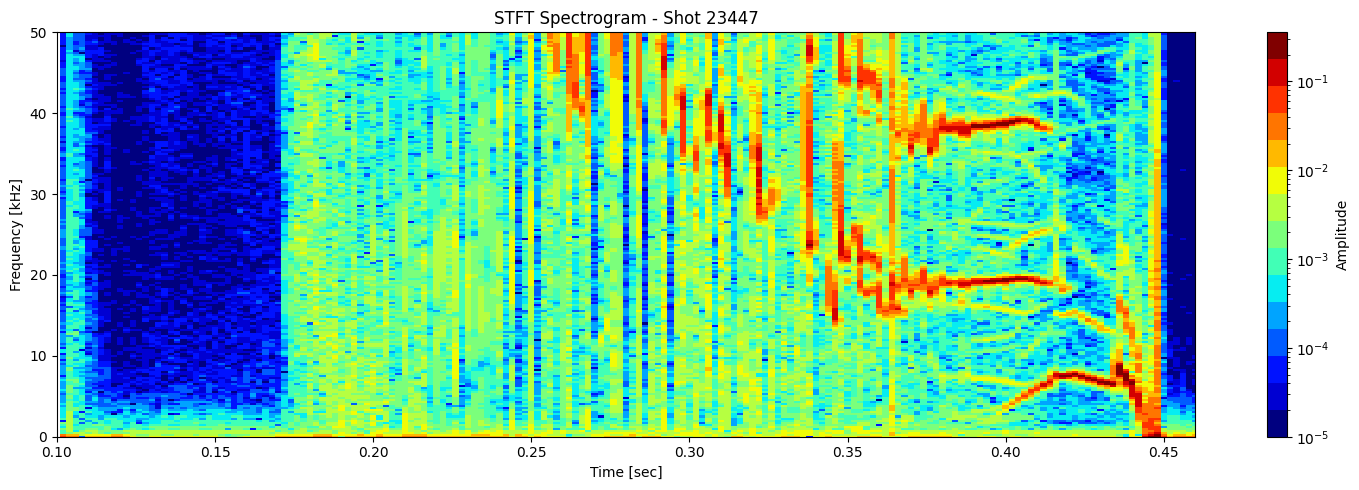

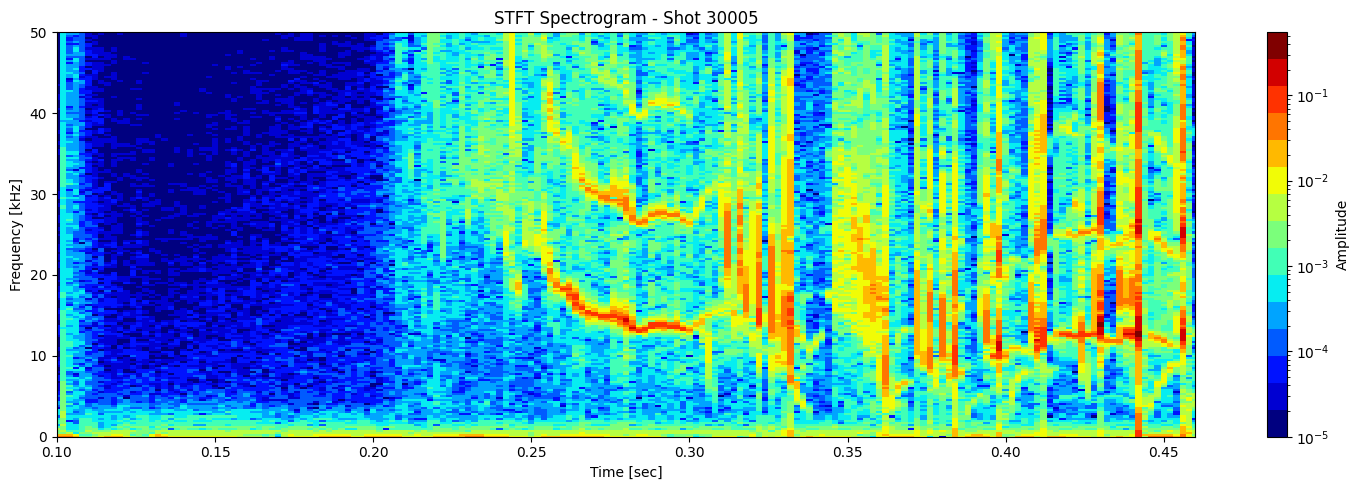

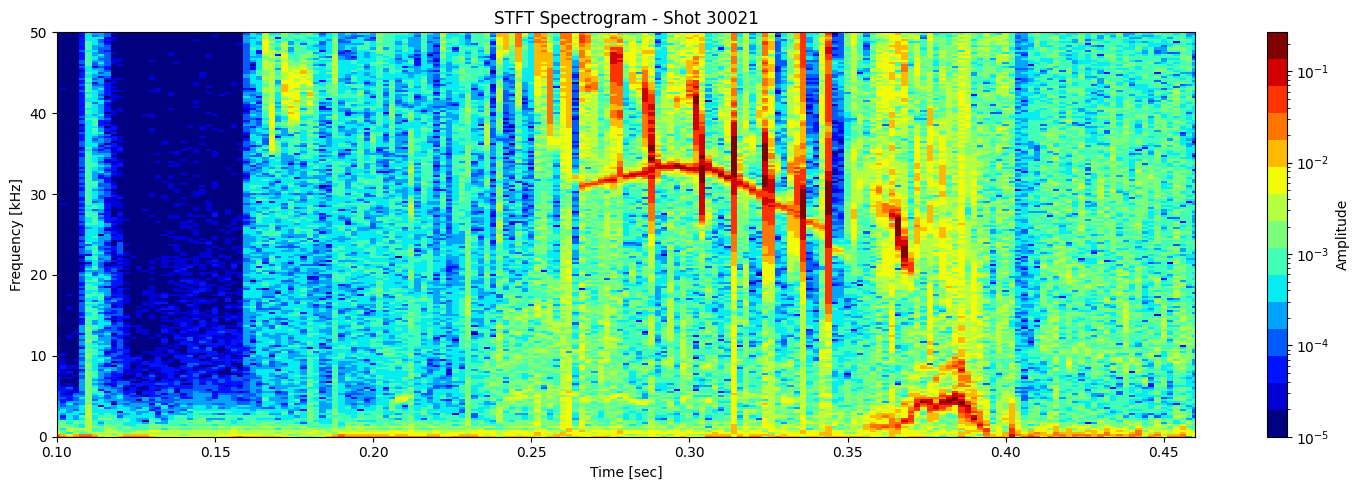

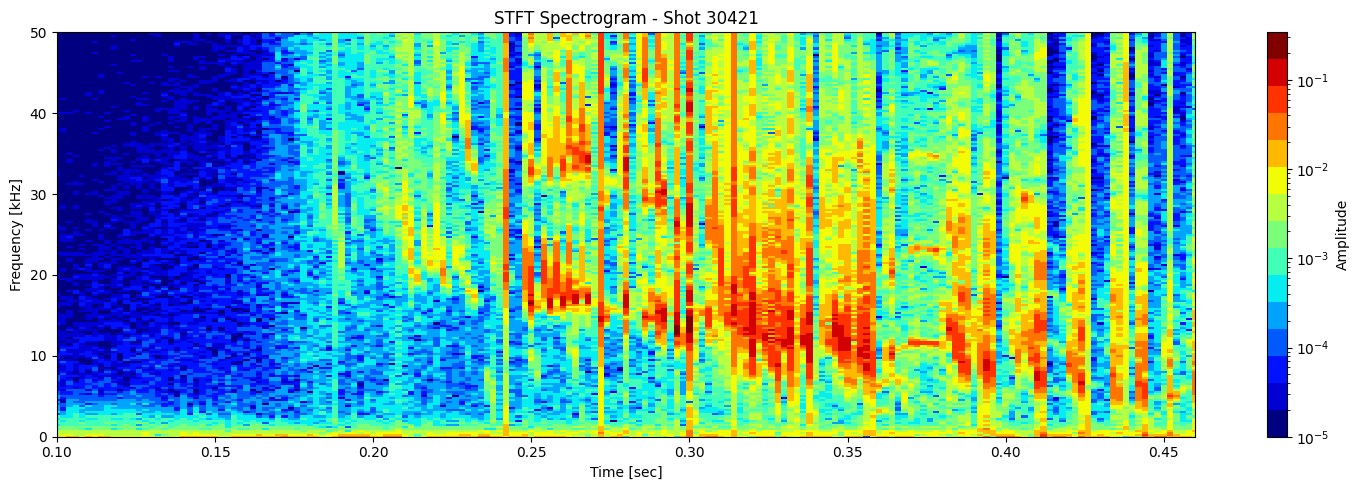

In [9]:
[plot_stft_spectrogram(ds_list[i], shot_ids[i]) for i in range(len(ds_list))]

### Inspect amplitude distribution

In [10]:
def plot_stft_histogram(    ds,    shot_id=None,    nperseg=2000,    nfft=2000,    bins=100
):
    """
    Plot a histogram of the absolute STFT amplitude values.

    Parameters:
    - ds: xarray.DataArray with a 'time_mirnov' coordinate.
    - shot_id: Optional shot ID for labeling.
    - nperseg: Number of points per STFT segment.
    - nfft: Number of FFT points.
    - bins: Number of histogram bins.
    """
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    plt.figure(figsize=(8, 4))
    plt.hist(np.abs(Zxx.flatten()), bins=bins, log=True)
    plt.xlabel('Amplitude')
    plt.ylabel('Count (log scale)')
    title = 'Histogram of Spectrogram Amplitudes'
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    return f, t, Zxx

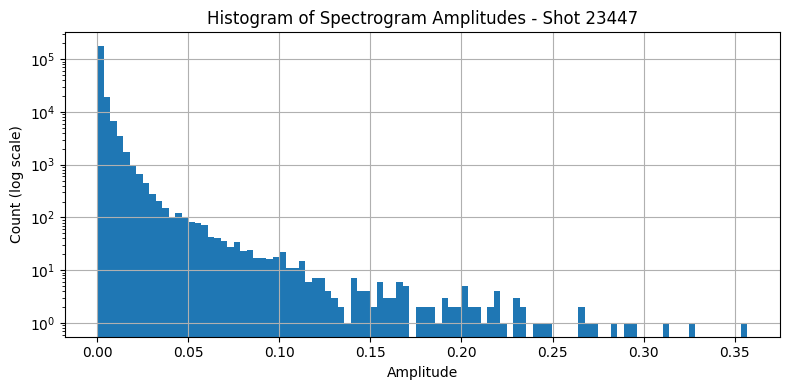

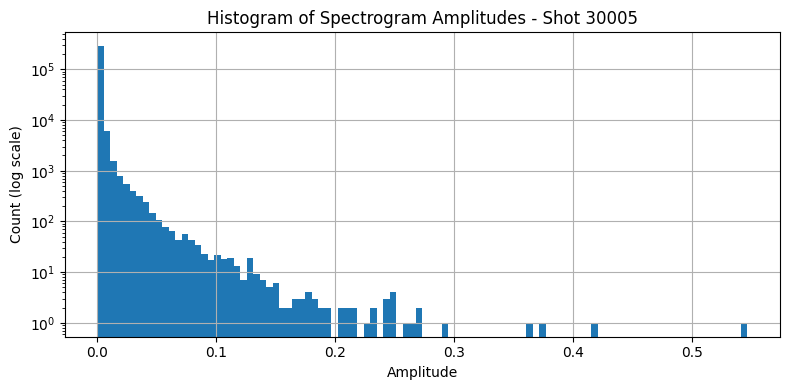

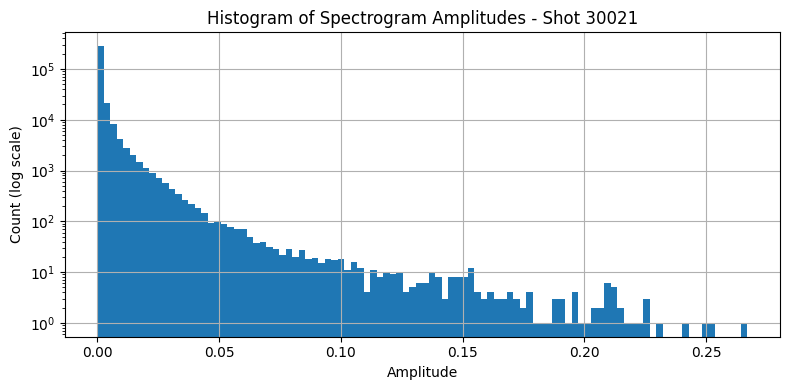

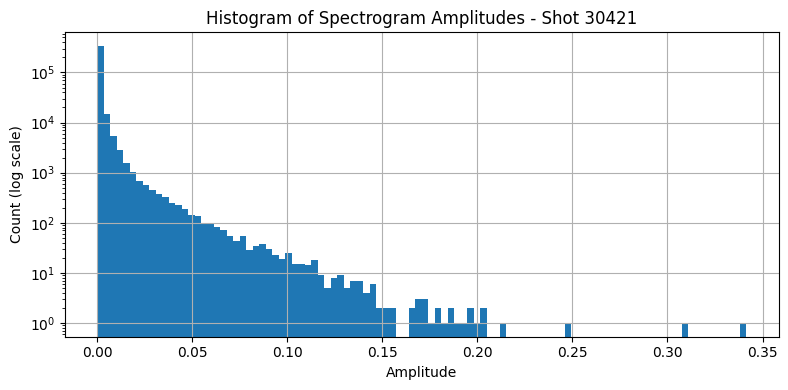

In [11]:
f_list, t_list, Zxx_list =  [], [], []
for i, ds in enumerate(ds_list):
    f, t, Zxx = plot_stft_histogram(ds_list[i], shot_ids[i])
    f_list.append(f)
    t_list.append(t)
    Zxx_list.append(Zxx)

#[plot_stft_histogram(ds_list[i], shot_ids[i]) for i in range(len(ds_list))]


In [14]:
def get_stft_contours(Zxx, f, t, threshold=1e-3):
    """
    Extract contour regions from STFT magnitude.
    
    Parameters:
    - Zxx: 2D STFT array (freq x time)
    - f: frequency array (Hz)
    - t: time array (sec)
    - threshold: amplitude threshold for contours
    
    Returns:
    - contours: list of Nx2 arrays (y: freq index, x: time index)
    - f, t can be used to map indices to physical values
    """
    magnitude = np.abs(Zxx)
    contours = measure.find_contours(magnitude, level=threshold)
    return contours

In [ ]:
def plot_spectrogram_with_contours(Zxx, f, t, contours, shot_id=None, vmin=1e-5):

    f_kHz = f / 1000

    fig, ax = plt.subplots(figsize=(12, 5))
    cax = ax.pcolormesh(t, f_kHz, np.abs(Zxx), shading='nearest',
                        norm=LogNorm(vmin=vmin), cmap='jet')

    for contour in contours:
        ax.plot(t[np.clip(contour[:, 1].astype(int), 0, len(t) - 1)],
                f_kHz[np.clip(contour[:, 0].astype(int), 0, len(f) - 1)],
                color='white', lw=1)

    ax.set_ylim(0, 50)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Frequency [kHz]')
    title = "STFT with Contour Overlay"
    if shot_id is not None:
        title += f" – Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label="Amplitude")
    plt.grid(True)
    plt.tight_layout()

[None, None, None, None]

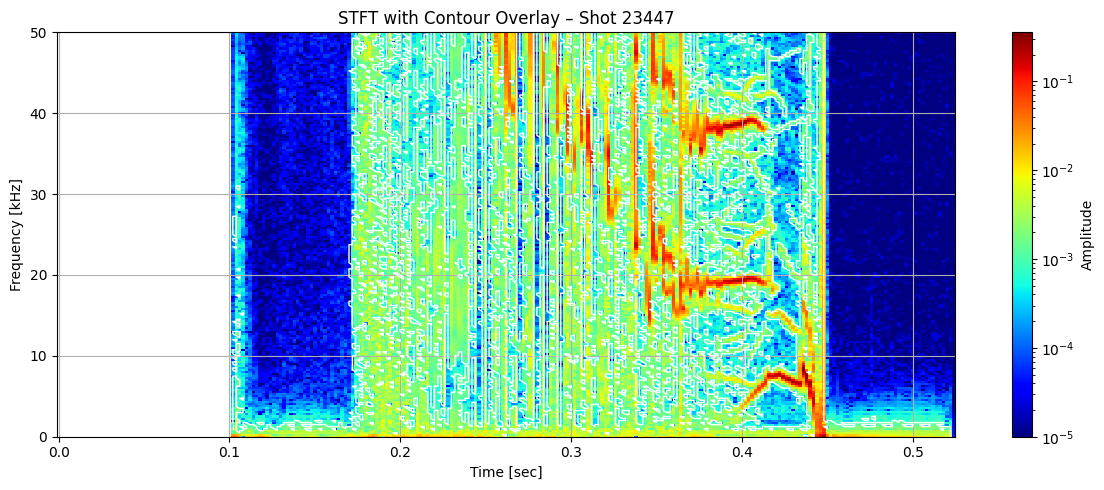

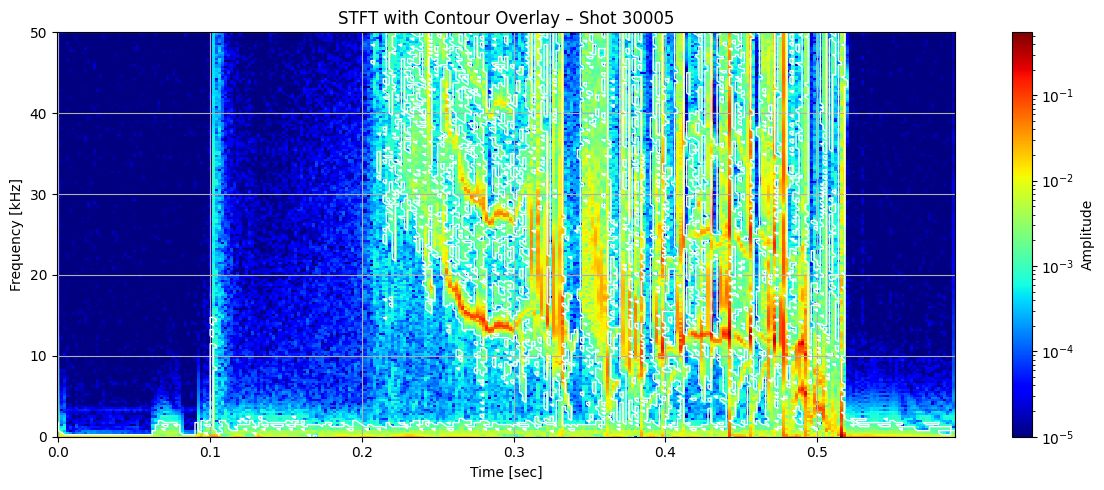

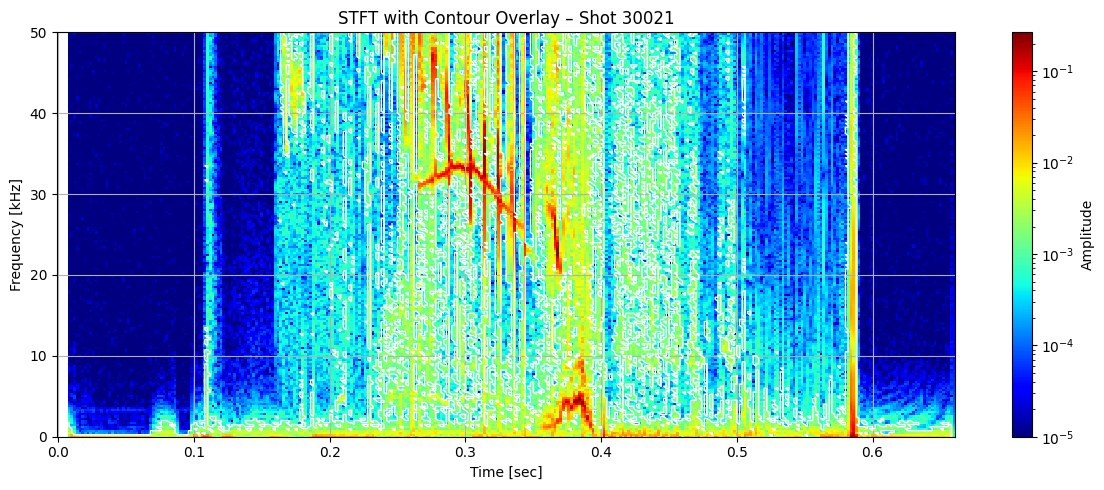

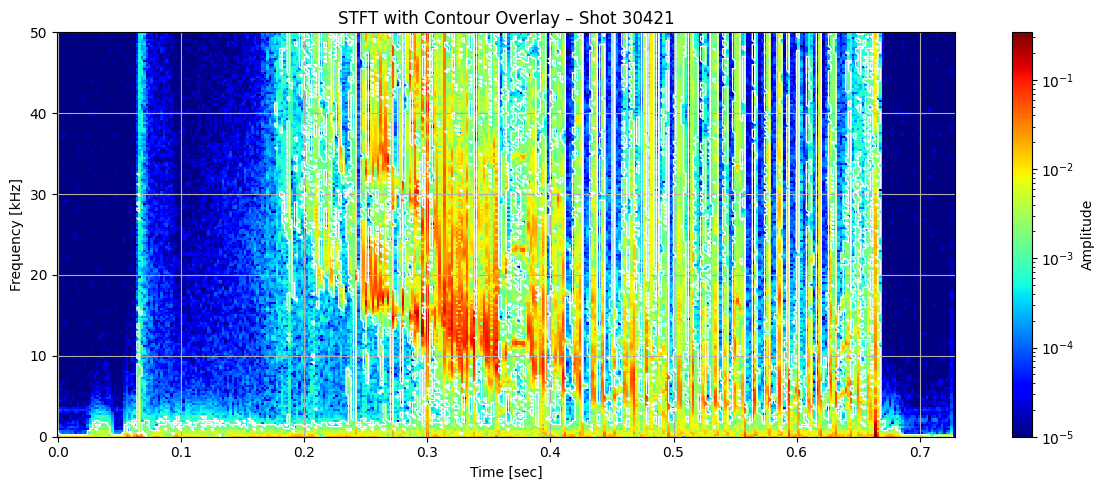

In [16]:
[plot_spectrogram_with_contours(Zxx_list[i], f_list[i], t_list[i], get_stft_contours(Zxx_list[i], f_list[i], t_list[i]), shot_ids[i]) for i in range(len(ds_list))]

##  Integrated Power Over Frequency Bands
We'll define bands (based on physics knowledge, e.g. 2/1 NTM ~10–15 kHz), then integrate STFT power over those frequency bands at each time step.

In [17]:
def compute_band_power(Zxx, f, band_kHz):
    """
    Compute power over a specified frequency band at each time step.

    Parameters:
    - Zxx: STFT array (freq x time)
    - f: frequency array (Hz)
    - band_kHz: tuple (f_min_kHz, f_max_kHz)

    Returns:
    - time_series: 1D array of power vs time
    """
    f_min_Hz = band_kHz[0] * 1000
    f_max_Hz = band_kHz[1] * 1000

    # Select indices in frequency range
    band_mask = (f >= f_min_Hz) & (f <= f_max_Hz)
    band_power = np.abs(Zxx[band_mask, :])**2

    # Integrate over frequency axis
    power_vs_time = band_power.sum(axis=0)

    return power_vs_time


In [19]:
def plot_band_power(t, power, band_kHz, shot_id=None):

    plt.figure(figsize=(10, 3))
    plt.plot(t, power, label=f"{band_kHz[0]}–{band_kHz[1]} kHz")
    plt.xlabel("Time [sec]")
    plt.ylabel("Integrated Power")
    title = f"Power in {band_kHz[0]}–{band_kHz[1]} kHz Band"
    if shot_id is not None:
        title += f" – Shot {shot_id}"
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


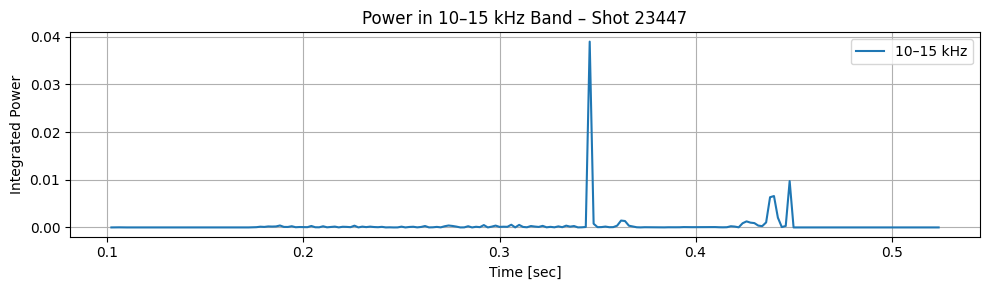

In [20]:
# Example: 2/1 NTM band from 10 to 15 kHz
power = compute_band_power(Zxx_list[0], f_list[0], band_kHz=(10, 15))
plot_band_power(t_list[0], power, band_kHz=(10, 15), shot_id=shot_ids[0])


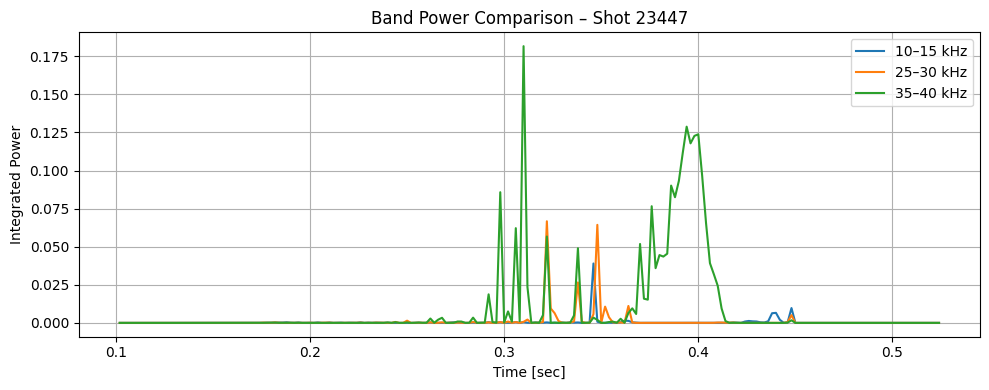

In [21]:
bands_kHz = [(10, 15), (25, 30), (35, 40)]
plt.figure(figsize=(10, 4))
for band in bands_kHz:
    power = compute_band_power(Zxx_list[0], f_list[0], band)
    plt.plot(t_list[0], power, label=f"{band[0]}–{band[1]} kHz")

plt.title(f"Band Power Comparison – Shot {shot_ids[0]}")
plt.xlabel("Time [sec]")
plt.ylabel("Integrated Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
def plot_spectrogram_with_bands(Zxx, f, t, bands_kHz, shot_id=None, vmin=1e-5):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    f_kHz = f / 1000
    fig, ax = plt.subplots(figsize=(12, 5))

    cax = ax.pcolormesh(t, f_kHz, np.abs(Zxx), shading='nearest',
                        norm=LogNorm(vmin=vmin), cmap='jet')

    # Overlay horizontal bands
    for band in bands_kHz:
        fmin, fmax = band
        ax.axhline(fmin, color='white', linestyle='--', lw=1)
        ax.axhline(fmax, color='white', linestyle='--', lw=1)
        ax.fill_between(t, fmin, fmax, color='white', alpha=0.1, label=f"{fmin}–{fmax} kHz")

    ax.set_ylim(0, 50)
    ax.set_xlim(t[0], t[-1])
    ax.set_xlabel("Time [sec]")
    ax.set_ylabel("Frequency [kHz]")
    title = "STFT with Mode Band Overlays"
    if shot_id is not None:
        title += f" – Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label="Amplitude")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

/tmp/ipykernel_1128234/3897467752.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


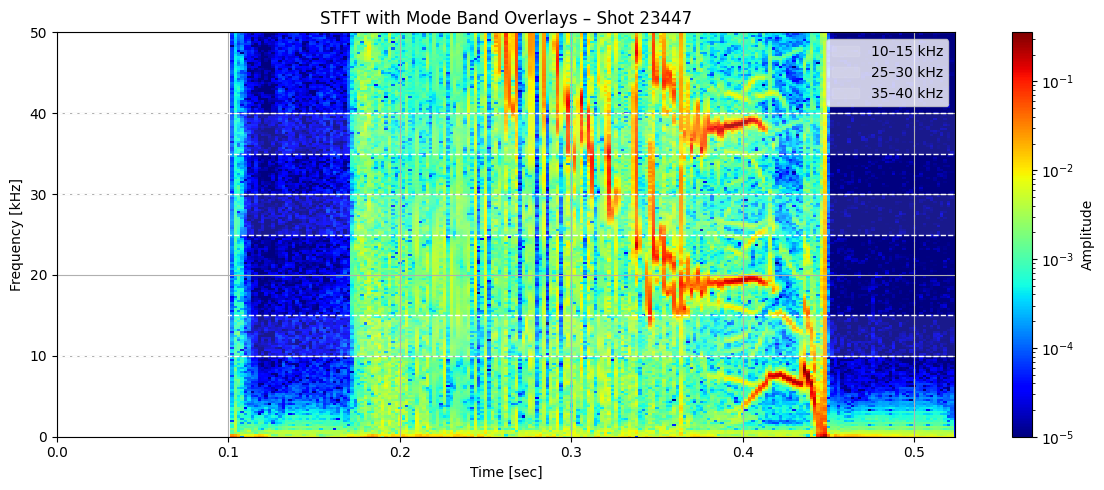

In [23]:
bands_kHz = [(10, 15), (25, 30), (35, 40)]  # You can adjust based on expected modes
plot_spectrogram_with_bands(Zxx_list[0], f_list[0], t_list[0], bands_kHz, shot_id=shot_ids[0])


In [24]:
def compute_binary_mask(Zxx, threshold=1e-3):
    """
    Generate binary mask of where |Zxx| >= threshold.
    """
    return np.abs(Zxx) >= threshold
from scipy.ndimage import label

def label_mode_events(binary_mask):
    """
    Label connected regions (events) in the binary mask.
    
    Returns:
    - labeled_mask: same shape as input, with each connected region labeled
    - num_events: number of detected blobs
    """
    structure = np.ones((3, 3))  # allow diagonal connections
    labeled_mask, num_events = label(binary_mask, structure=structure)
    return labeled_mask, num_events
def extract_event_properties(labeled_mask, f, t, band_kHz):
    """
    Extract properties of each mode event that lies within a band.
    
    Parameters:
    - labeled_mask: output of label()
    - f: frequency array (Hz)
    - t: time array (sec)
    - band_kHz: frequency band (tuple)

    Returns:
    - events: list of dicts with event properties
    """
    events = []
    band_min = band_kHz[0] * 1000
    band_max = band_kHz[1] * 1000

    for label_val in range(1, labeled_mask.max() + 1):
        coords = np.argwhere(labeled_mask == label_val)
        freqs = f[coords[:, 0]]
        times = t[coords[:, 1]]

        # Check if event overlaps with the band
        if np.any((freqs >= band_min) & (freqs <= band_max)):
            event = {
                "label": label_val,
                "start_time": times.min(),
                "end_time": times.max(),
                "duration": times.max() - times.min(),
                "min_freq_kHz": freqs.min() / 1000,
                "max_freq_kHz": freqs.max() / 1000,
                "band": band_kHz
            }
            events.append(event)
    
    return events


In [26]:
import pandas as pd
from matplotlib.patches import Rectangle

def display_event_table(events):
    df = pd.DataFrame(events)
    display(df)
Zxx = Zxx_list[0]
f = f_list[0]
t = t_list[0]

mask = compute_binary_mask(Zxx, threshold=1e-3)
labeled_mask, num_events = label_mode_events(mask)
events = extract_event_properties(labeled_mask, f, t, band_kHz=(10, 15))
display_event_table(events)


,label,start_time,end_time,duration,min_freq_kHz,max_freq_kHz,band
0,1,0.102000,0.522001,0.420001,0.000000,249.999500,"(10, 15)"
1,23,0.104000,0.106000,0.002000,10.249980,11.499977,"(10, 15)"
2,24,0.412001,0.412001,0.000000,10.249980,10.499979,"(10, 15)"
3,25,0.380001,0.380001,0.000000,10.999978,10.999978,"(10, 15)"
4,26,0.244000,0.244000,0.000000,11.249978,11.749977,"(10, 15)"
5,27,0.104000,0.104000,0.000000,11.999976,11.999976,"(10, 15)"
6,28,0.416001,0.416001,0.000000,11.999976,11.999976,"(10, 15)"
7,29,0.374001,0.376001,0.002000,12.249976,12.749975,"(10, 15)"
8,30,0.104000,0.106000,0.002000,12.499975,12.999974,"(10, 15)"
9,31,0.380001,0.380001,0.000000,12.749975,13.249974,"(10, 15)"


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm

def plot_spectrogram_with_events(Zxx, f, t, events, shot_id=None, vmin=1e-5):
    """
    Plot STFT with bounding boxes around detected mode events.

    Parameters:
    - Zxx: STFT array (freq x time)
    - f: frequency array (Hz)
    - t: time array (sec)
    - events: list of dicts from extract_event_properties()
    - shot_id: Optional shot ID
    """
    f_kHz = f / 1000
    fig, ax = plt.subplots(figsize=(12, 5))

    cax = ax.pcolormesh(t, f_kHz, np.abs(Zxx), shading='nearest',
                        norm=LogNorm(vmin=vmin), cmap='jet')

    for event in events:
        x = event['start_time']
        width = event['end_time'] - event['start_time']
        y = event['min_freq_kHz']
        height = event['max_freq_kHz'] - event['min_freq_kHz']
        label = f"{event['band'][0]}–{event['band'][1]} kHz"

        rect = Rectangle((x, y), width, height,
                         linewidth=1.5, edgecolor='white', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ax.text(x, y + 0.5, label, color='white', fontsize=8, va='bottom')

    ax.set_ylim(0, 50)
    ax.set_xlabel("Time [sec]")
    ax.set_ylabel("Frequency [kHz]")
    title = "STFT with Detected Mode Events"
    if shot_id is not None:
        title += f" – Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label="Amplitude")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


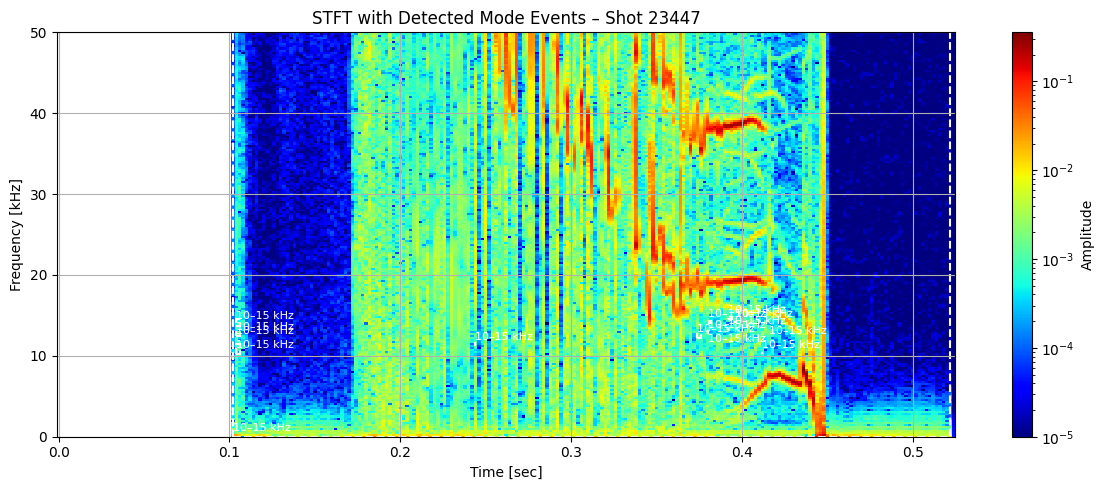

In [49]:
mask = compute_binary_mask(Zxx_list[0], threshold=1e-3)
labeled_mask, _ = label_mode_events(mask)
events = extract_event_properties(labeled_mask, f_list[0], t_list[0], band_kHz=(10, 15))

plot_spectrogram_with_events(Zxx_list[0], f_list[0], t_list[0], events, shot_id=shot_ids[0])


In [52]:
def plot_spectrogram_with_events(Zxx, f, t, events, shot_id=None, vmin=1e-5):

    f_kHz = f / 1000
    fig, ax = plt.subplots(figsize=(12, 5))

    # cax = ax.pcolormesh(t, f_kHz, np.abs(Zxx), shading='nearest',
    #                     norm=LogNorm(vmin=vmin), cmap='jet')

    for i, event in enumerate(events):
        x = event['start_time']
        width = event['end_time'] - event['start_time']
        y = event['min_freq_kHz']
        height = event['max_freq_kHz'] - event['min_freq_kHz']
        band_str = f"{event['band'][0]}–{event['band'][1]} kHz"

        rect = Rectangle((x, y), width, height,
                         linewidth=1, edgecolor='white',
                         facecolor='orange', alpha=0.3)
        ax.add_patch(rect)
        ax.text(x + 0.002, y + height + 0.8, band_str,
                color='black', fontsize=8, weight='bold', bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

    ax.set_ylim(0, 50)
    ax.set_xlim(t[0], t[-1])
    ax.set_xlabel("Time [sec]")
    ax.set_ylabel("Frequency [kHz]")
    title = "STFT with Detected Mode Events"
    if shot_id is not None:
        title += f" – Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label="Amplitude")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


NameError: name 'cax' is not defined

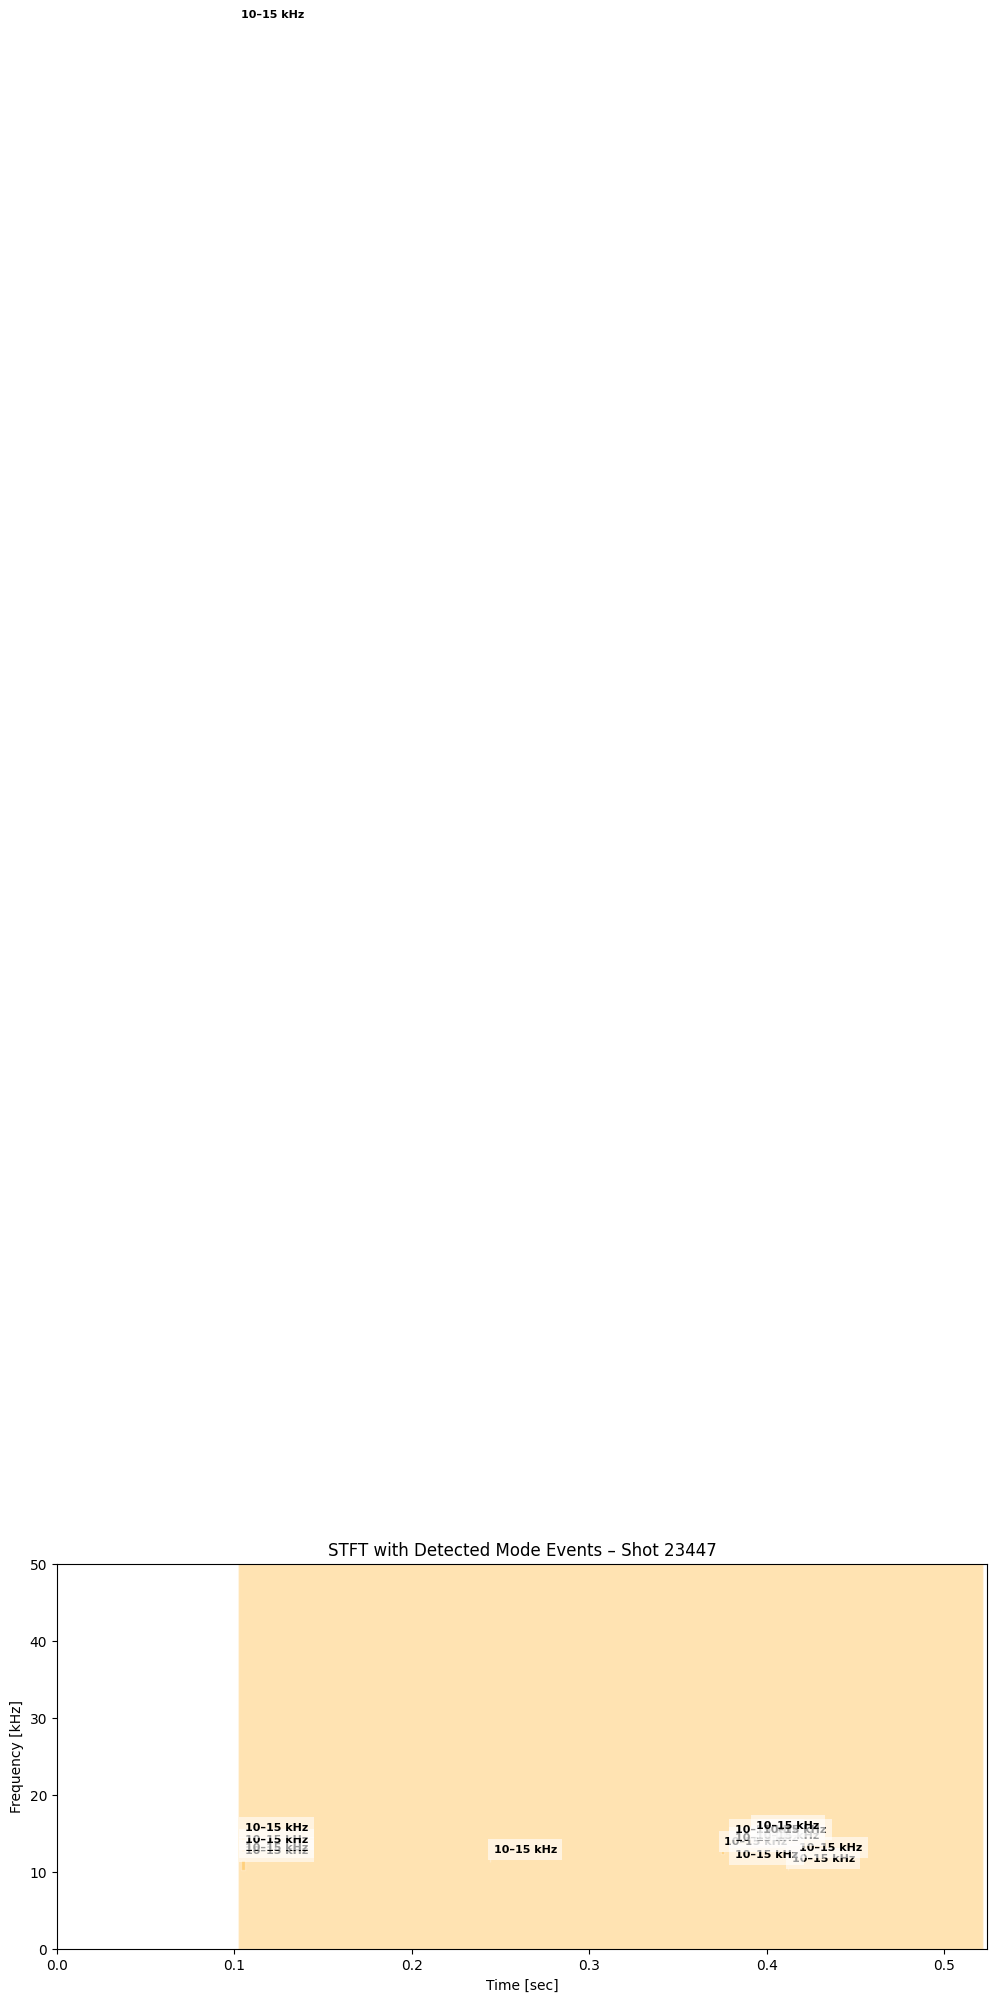

In [53]:
mask = compute_binary_mask(Zxx_list[0], threshold=1e-3)
labeled_mask, _ = label_mode_events(mask)
events = extract_event_properties(labeled_mask, f_list[0], t_list[0], band_kHz=(10, 15))

plot_spectrogram_with_events(Zxx_list[0], f_list[0], t_list[0], events, shot_id=shot_ids[0])


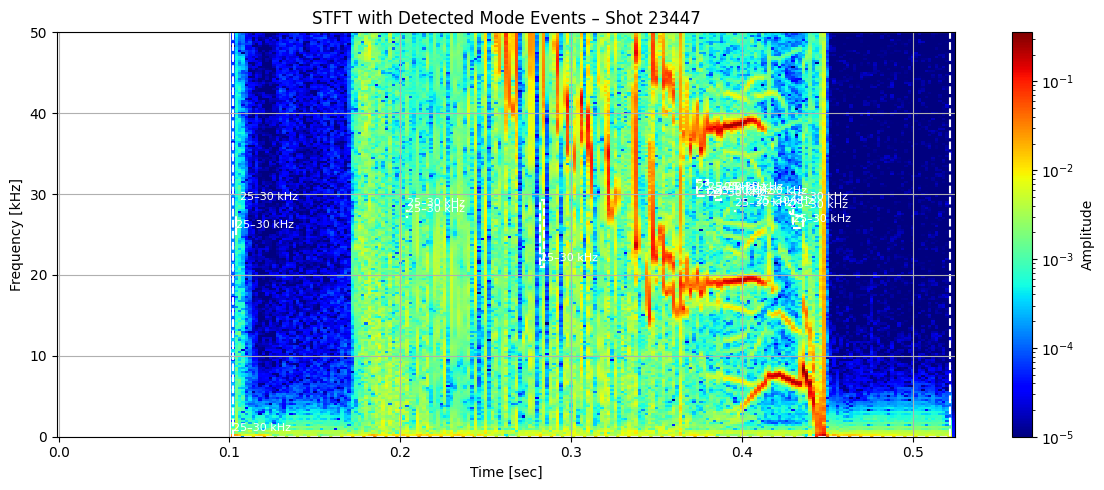

In [50]:
mask = compute_binary_mask(Zxx_list[0], threshold=1e-3)
labeled_mask, _ = label_mode_events(mask)
events = extract_event_properties(labeled_mask, f_list[0], t_list[0], band_kHz=(25, 30))

plot_spectrogram_with_events(Zxx_list[0], f_list[0], t_list[0], events, shot_id=shot_ids[0])


NameError: name 'cax' is not defined

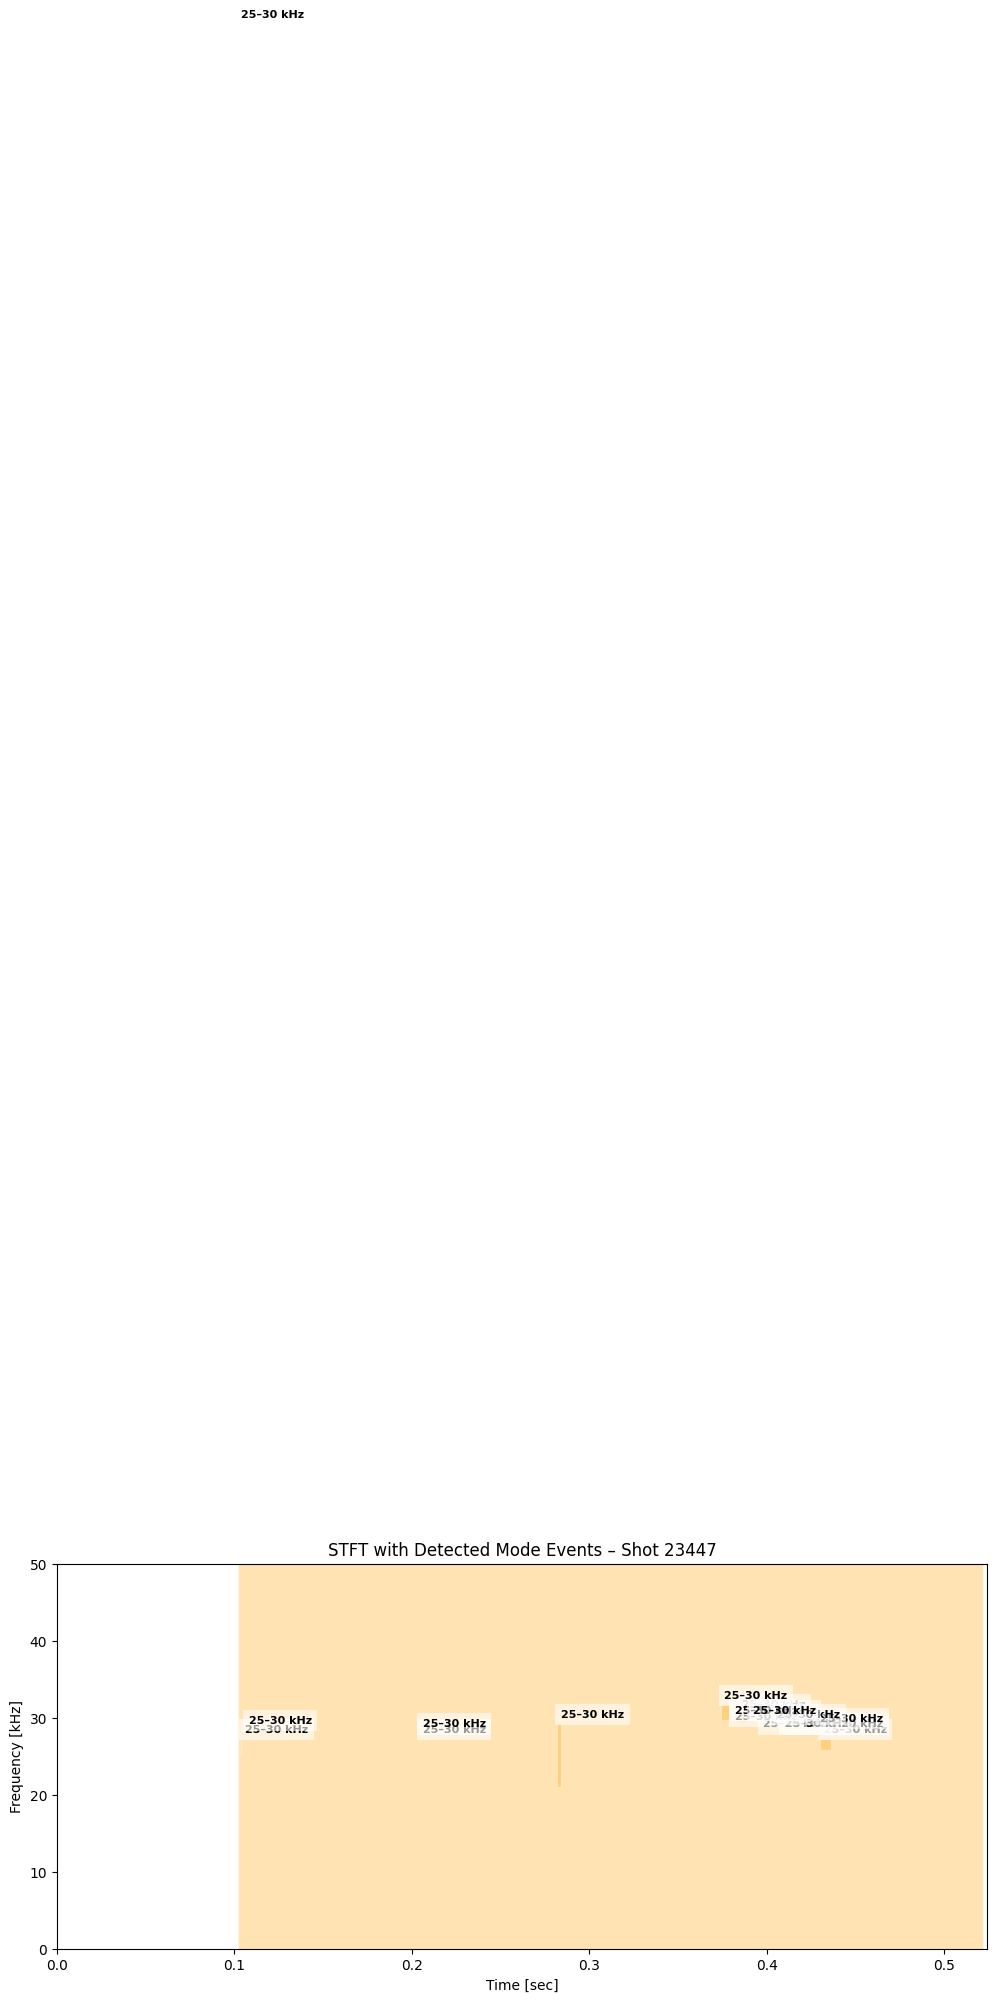

In [54]:
mask = compute_binary_mask(Zxx_list[0], threshold=1e-3)
labeled_mask, _ = label_mode_events(mask)
events = extract_event_properties(labeled_mask, f_list[0], t_list[0], band_kHz=(25, 30))

plot_spectrogram_with_events(Zxx_list[0], f_list[0], t_list[0], events, shot_id=shot_ids[0])
